In [1]:
from scipy.integrate import solve_ivp
from data.budworm import budworm_ode, simulate_steady_state
from sympy import symbols, Eq, solve, simplify
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn

from stabnode.node import Felu, Gelu, StabNODE, model_trainer, set_global_seed

In [2]:
set_global_seed(seed=1234)

In [3]:
def get_roots():
    """
    roots of descriminant of associated ode cubic in k.
    """
    r, k = symbols('r k', positive=True)
    a = r/k
    b = -r
    c = (k+r)/k
    d = -r
    p = (3*a*c-b**2) / (3*a**2)
    q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)
    
    D = - (4*p**3 + 27*q**2)
    D = simplify(D)
    
    
    D_fixed = D.subs(r, 0.56)
    r1, r2 = solve(Eq(D_fixed, 0), k)
    return r1, r2


In [4]:
r1, r2 = get_roots()
k_vals = np.linspace(float(r1)-1, float(r2)+1,250)

In [5]:
x0 = 1

k_start = k_vals[0]
k_end = k_vals[-1]
n_points = 250

k_increase = np.linspace(k_start,k_end, n_points)
k_decrease = np.linspace(k_increase[-1],k_start,n_points)

In [6]:
x_increase = simulate_steady_state(k_increase,x0=x0)
x_decrease = simulate_steady_state(k_decrease, x0=x_increase[-1])

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [7]:
X = np.hstack((x_increase,x_decrease))
K = np.hstack((k_increase, k_decrease))

repeat = 2
for _ in range(repeat):
    X = np.hstack((X,X))
    K = np.hstack((K,K))

tau = torch.arange(0, len(K), device = 'cpu')

In [8]:
device = 'cpu'
sample_rate = 10
noise = 0.05
scaler = MinMaxScaler(feature_range=(-1,1))
X_scaled = scaler.fit_transform(X.reshape(-1,1))
X_scaled = torch.tensor(X_scaled,dtype=torch.float32, device=device)

tau_train = tau[::sample_rate]
X_train = X_scaled[tau_train]
K_train = K[tau_train]

noise_arr = torch.randn_like(X_train) * noise
X_train = X_train + noise_arr

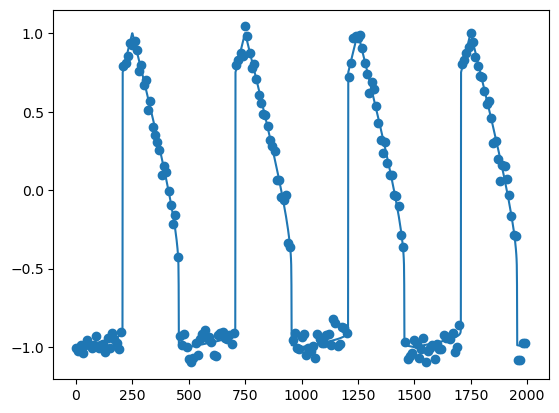

In [9]:
plt.plot(X_scaled)
plt.scatter(tau_train, X_train)
plt.show()

In [10]:
f_dim = 6
g_dim =2 

def K_func(tau):
    idx = int(tau) % len(K)
    return torch.tensor(K[idx],dtype=torch.float32, device=device) 


dim_in = X_train.shape[-1]
dim_out = X_train.shape[-1]

f = Felu(dim_in, dim_out, f_dim)
g = Gelu(dim_in+1, dim_out, g_dim)

stab_node = StabNODE(f,g)
stab_node.to(device)
    

StabNODE(
  (f): Felu(
    (network): Sequential(
      (0): Linear(in_features=1, out_features=6, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=6, out_features=1, bias=True)
    )
  )
  (g): Gelu(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=2, out_features=1, bias=True)
      (3): Tanh()
    )
  )
)

In [11]:
lr = 0.1
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = lr)
tau_span = tau_train.clone().detach().to(dtype=torch.float32, device=device)
x0 = X_train[0].reshape(-1, 1).clone().detach().to(dtype=torch.float32,device=device)
x0.requires_grad_(True)

tensor([[-1.0056]], requires_grad=True)

In [12]:
stab_node, log_history = model_trainer(
              stab_node,
              opt,
              loss_criteria,
              x0,
              tau_span,
              X_train,
              K_func,
              n_epochs=10,
              min_improvement=1e-4,
              patience=100,
              print_every=1,
              solve_method='rk4',
              show_progress=True,
              save_path="test.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: Loss = 34.2748, time = 0.3386
test
Epoch 1: Loss = 11099.2002, time = 0.3479
test
Epoch 2: Loss = 795.4796, time = 0.3455
test
Epoch 3: Loss = 618.3088, time = 0.3494
test
Epoch 4: Loss = 230.1868, time = 0.3491
test
Epoch 5: Loss = 16119.4727, time = 0.3489
test
Epoch 6: Loss = 39408.0312, time = 0.3504
test
Epoch 7: Loss = 495.8828, time = 0.3481
test
Epoch 8: Loss = 1203.1743, time = 0.3498
test
Epoch 9: Loss = 14935.1885, time = 0.3511
test


# All $t$ values

In [15]:
x0=1
r=0.56
k_start = k_vals[0]
k_end = k_vals[-1]
n_points = 250

k_increase = np.linspace(k_start,k_end, n_points)
k_decrease = np.linspace(k_increase[-1],k_start,n_points)
k = k_increase[0]

In [16]:
tspan = [0,50]
x_curr = x0
t_eval = np.linspace(tspan[0], tspan[-1], 51)


In [19]:
from data.utils import _load_wrapper
def simulate_steady_state(k_evals, x0,t_eval: None,show_progress:bool = True):

    wrapper = _load_wrapper(show_progress)
    t_span = [0,50]
    if t_eval is None:
        t_eval = [t_span[-1]]
    r=0.56
    x_vals = []
    t_vals = []
    k_vals = []
    dt = t_eval[1] - t_eval[0]
    x_curr = x0
    for idx, k in enumerate(wrapper(k_evals)):
        sol = solve_ivp(budworm_ode, t_span=t_span, y0=[x_curr],args = (r,k,), t_eval=t_eval)
        xi = sol.y[0][:-1]
        x_curr = xi[-1]
        
        x_vals = np.hstack((x_vals,xi))
        if idx > 0:
            shift = dt
        else:
            shift = 0
        t_vals = np.hstack((t_vals, sol.t[:-1]+idx*t_span[-1]+shift))
        k_vals = np.hstack((k_vals, [k]*len(t_eval[:-1])))
        
    return x_vals, t_vals, k_vals

In [26]:
x_increase, ts, ks = simulate_steady_state(k_increase,1,t_eval)
x_decrease, ts2, ks2 = simulate_steady_state(k_decrease, x0 = x_increase[-1],t_eval=t_eval)
ts2 += ts[-1]


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [37]:
X = np.hstack((x_increase, x_decrease))
T = np.hstack((ts, ts2))
K = np.hstack((ks,ks2))

repeat = 2
for _ in range(repeat):
    X = np.hstack((X,X))
    t1 = T[-1]
    T = np.hstack((T, T+t1))
    K = np.hstack((K,K))

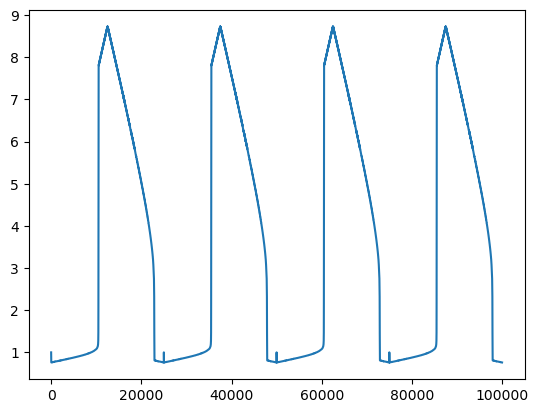

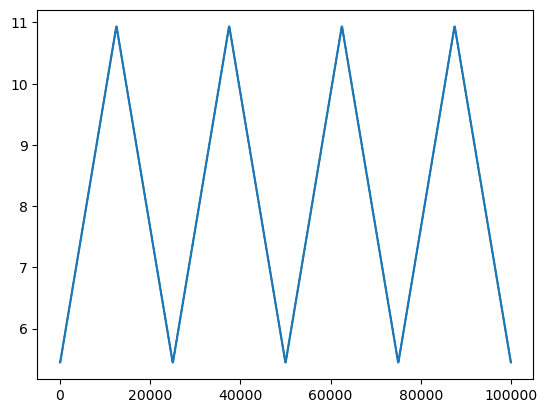

In [38]:
plt.plot(T, X)
plt.show()
plt.plot(T,K)
plt.show()

In [56]:
dt = sol.t[1] - sol.t[0]
len(sol.t)
count=3
t_eval[:-1]+count*50+dt

array([150.2, 150.4, 150.6, 150.8, 151. , 151.2, 151.4, 151.6, 151.8,
       152. , 152.2, 152.4, 152.6, 152.8, 153. , 153.2, 153.4, 153.6,
       153.8, 154. , 154.2, 154.4, 154.6, 154.8, 155. , 155.2, 155.4,
       155.6, 155.8, 156. , 156.2, 156.4, 156.6, 156.8, 157. , 157.2,
       157.4, 157.6, 157.8, 158. , 158.2, 158.4, 158.6, 158.8, 159. ,
       159.2, 159.4, 159.6, 159.8, 160. , 160.2, 160.4, 160.6, 160.8,
       161. , 161.2, 161.4, 161.6, 161.8, 162. , 162.2, 162.4, 162.6,
       162.8, 163. , 163.2, 163.4, 163.6, 163.8, 164. , 164.2, 164.4,
       164.6, 164.8, 165. , 165.2, 165.4, 165.6, 165.8, 166. , 166.2,
       166.4, 166.6, 166.8, 167. , 167.2, 167.4, 167.6, 167.8, 168. ,
       168.2, 168.4, 168.6, 168.8, 169. , 169.2, 169.4, 169.6, 169.8,
       170. , 170.2, 170.4, 170.6, 170.8, 171. , 171.2, 171.4, 171.6,
       171.8, 172. , 172.2, 172.4, 172.6, 172.8, 173. , 173.2, 173.4,
       173.6, 173.8, 174. , 174.2, 174.4, 174.6, 174.8, 175. , 175.2,
       175.4, 175.6,

In [33]:
# test = []
test = np.hstack((test,xi))

In [36]:
type(test)

numpy.ndarray

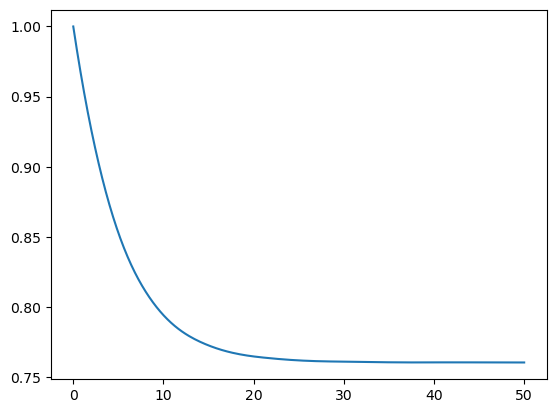

In [20]:
plt.plot(sol.t.reshape(-1),sol.y.reshape(-1))

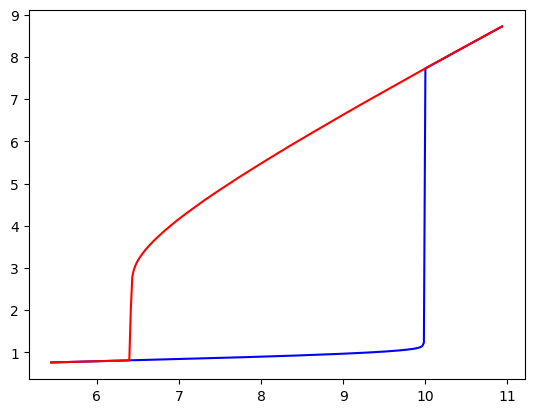

In [7]:
plt.plot(k_increase, x_increase, c='blue', label=r"increasing $k$")
plt.plot(k_decrease, x_decrease, c='red', label=r"decreasing $k$")
plt.show()